In [1]:
import pandas as pd

df = pd.read_csv('./amazon_uk_shoes_products_dataset_2021_12.csv') # 현재 위치에 있는 csv파일 불러옴
df.head() # 제대로 파일이 출력되는지 확인

,url,product_name,reviewer_name,review_title,review_text,review_rating,verified_purchase,review_date,helpful_count,uniq_id,scraped_at
0,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Jocelyn McSayles,Love em,Love these. Was looking for converses and thes...,5.0,True,Reviewed in the United States on 2 June 2020,2 people found this helpful,36eae4e5-2894-5279-a0b7-d2b330e2b814,24/12/2021 02:26:25
1,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Kenia Rivera,The plastic ripped,"The shoes are very cute, but after the 2nd day...",2.0,True,Reviewed in the United States on 28 October 2021,NaN,f4778bb8-3070-5cb1-b5aa-ffce41a97b57,24/12/2021 02:26:25
2,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Chris Souza,Good quality,Good quality,5.0,True,Reviewed in the United States on 20 January 2021,NaN,db5a7525-d40b-5265-84d8-df4f29837a3b,24/12/2021 02:26:25
3,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Amazon Customer,Good,Great,5.0,True,Reviewed in the United States on 22 April 2021,NaN,75a42851-6462-54b5-988a-27d336221943,24/12/2021 02:26:25
4,https://www.amazon.co.uk/dp/B08SW434MG,"GUESS Women's Bradly Gymnastics Shoe, White, 7 UK",Graziella,PERFETTE!!,Ho scelto il modello bianco con rifinitura die...,5.0,True,Reviewed in Italy on 2 April 2021,2 people found this helpful,232dee43-849e-5d06-ba05-efb3f4814714,24/12/2021 02:26:25


In [2]:
import re

df['review_text'] = df['review_text'].fillna('') # 결측값 제거
df['review_text'] = df['review_text'].astype(str) # 문자열 변환

# 노이즈 제거
df['review_text'] = df['review_text'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))  # 특수 문자 제거
df['review_text'] = df['review_text'].apply(lambda x: re.sub(r'\d+', '', x))          # 숫자 제거
df['review_text'] = df['review_text'].apply(lambda x: re.sub(r'\s+', ' ', x).strip()) # 불필요한 공백 제거

In [3]:
import nltk
nltk.download('stopwords') # nltk 불용어 리스트 다운
nltk.download('punkt') # 토큰화 도구

from nltk.corpus import stopwords # nltk 불용어 모듈
from nltk.tokenize import word_tokenize # 단어 단위로 토큰화 위해 word_tokenize 함수 사용

stop_words = set(stopwords.words('english')) # 불용어 리스트 변수에 저장 
df['review_text'] = df['review_text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))
# review_text 토큰화 후 불용어에 해당하지 않는 단어만 포함시키는 리스트 생성

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
from nltk.stem import PorterStemmer, WordNetLemmatizer # 스테밍과 표제어 추출을 위함
nltk.download('wordnet') # 표제어 추출을 위함

# 스테밍 적용
stemmer = PorterStemmer()
df['review_text'] = df['review_text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...


In [5]:
# 표제어 추출 적용
lemmatizer = WordNetLemmatizer()
df['review_text'] = df['review_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))

In [6]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

vader_sentiment = SentimentIntensityAnalyzer() # VADER 감정 분석기 초기화

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/codespace/nltk_data...


In [7]:
# 감정 점수 계산 함수
def calc_sentiment(review):
    return vader_sentiment.polarity_scores(review)["compound"] # VADER 감정 분석의 compound 점수는 -1에서 1 사이의 값을 가지며, 이는 감정의 강도를 나타냄

df['sentiment_score'] = df['review_text'].apply(calc_sentiment) # 감정 점수 컬럼 추가

print(df[['review_text', 'sentiment_score']].head()) # 결과 출력

                                         review_text  sentiment_score
0  love look convers half price uniqu ive never s...           0.9188
1  shoe cute nd day wear tongu start rip rd day w...           0.2240
2                                       good qualiti           0.4404
3                                              great           0.6249
4  ho scelto il modello bianco con rifinitura die...          -0.4588


In [8]:
# 리뷰의 별점과 라벨링된 감정 점수가 일치하는지 확인하는 함수
def check_labeling(review_rating, sentiment_label):
    if review_rating >= 2 and sentiment_label == 1:
        return "Match"
    elif review_rating < 2 and sentiment_label == 0:
        return "Match"
    else:
        return "Mismatch"

# review_rating과 라벨링된 감정 점수 비교
df['sentiment_label'] = df['sentiment_score'].apply(lambda x: 1 if x >= 0 else 0)  # 감정 점수에 따라 라벨링 (감정점수 0이상이면 긍정인 1, 0 미만인 부정이면 0으로 라벨링)
df['Check_Labeling'] = df.apply(lambda row: check_labeling(row['review_rating'], row['sentiment_label']), axis=1)

# 결과 출력
print(df[['review_rating', 'sentiment_label', 'Check_Labeling']])

# Match로 출력되는 비율 계산
match_count = (df['Check_Labeling'] == 'Match').sum() # 'Check_Labeling' 열에서 'Match'인 항목의 수를 세고 match_count에 저장
total_count = len(df) # DataFrame의 총 행 수를 total_count에 저장
match_ratio = match_count / total_count # 'Match'로 출력되는 비율을 계산하여 match_ratio에 저장
print("matching ratio", match_ratio) # 'Match'로 출력되는 비율 출력


      review_rating  sentiment_label Check_Labeling
0               5.0                1          Match
1               2.0                1          Match
2               5.0                1          Match
3               5.0                1          Match
4               5.0                0       Mismatch
...             ...              ...            ...
6818            5.0                1          Match
6819            5.0                1          Match
6820            5.0                1          Match
6821            5.0                0       Mismatch
6822            5.0                0       Mismatch

[6823 rows x 3 columns]
matching ratio 0.8330646343250769


In [9]:
# 특성과 라벨을 분리
X = df['sentiment_score'].values.reshape(-1, 1) # 감정 점수
y = df['sentiment_label'] # 감정 점수에 기반한 라벨 (위에서 라벨링한 것)

In [10]:
from sklearn.model_selection import train_test_split

# 모델을 학습시킨 후 성능 평가 위해 데이터셋 학습 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 주어진 데이터셋을 학습 데이터와 테스트 데이터로 8:2비율로 나누고 random_state를 42로 설정하여 데이터 분할할 때 일관된 결과를 얻도록 함

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

model = LogisticRegression() # 로지스틱 회귀 모델 초기화

param_grid = {'C': [0.1, 1, 10, 100]} # 하이퍼파라미터 그리드 정의

grid_search = GridSearchCV(model, param_grid, cv=5) # 그리드 서치 수행
#cv=5는 5겹 교차 검증을 의미하는데 기본값이 5임
grid_search.fit(X_train, y_train) # 학습 세트로 모델 학습

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10, 100]})

In [12]:
print("Best parameters found: ", grid_search.best_params_) # 그리드 서치를 통해 찾은 최적 하이퍼파라미터 출력

Best parameters found:  {'C': 100}


In [13]:
# 최적 모델로 예측 수행
best_model = grid_search.best_estimator_ # 최적 모델을 best_model에 할당
y_pred = best_model.predict(X_test) # X_text데이터에 대한 예측값을 변수에 저장

In [15]:
from sklearn.model_selection import cross_val_score

# 5-겹 교차 검증 수행을 통해 오버피팅 해결함

cv_accuracy = cross_val_score(best_model, X, y, cv=5, scoring='accuracy').mean() # 정확도
cv_precision = cross_val_score(best_model, X, y, cv=5, scoring='precision').mean() # 정밀도 
cv_recall = cross_val_score(best_model, X, y, cv=5, scoring='recall').mean() # 재현률
cv_f1 = cross_val_score(best_model, X, y, cv=5, scoring='f1').mean() # F1 점수 
cv_roc_auc = cross_val_score(best_model, X, y, cv=5, scoring='roc_auc').mean() # ROC-AUC

print("CV Accuracy: ", cv_accuracy)
print("CV Precision: ", cv_precision)
print("CV Recall: ", cv_recall)
print("CV F1 Score: ", cv_f1)
print("CV ROC-AUC Score: ", cv_roc_auc)

CV Accuracy:  0.9956035362486976
CV Precision:  0.994977225587651
CV Recall:  1.0
CV F1 Score:  0.9974808925241803
CV ROC-AUC Score:  1.0


In [14]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score

# 정확도 및 분류 보고서 출력
accuracy = accuracy_score(y_test, y_pred) # 정확도
precision = precision_score(y_test, y_pred) # 정밀도
recall = recall_score(y_test, y_pred) # 재현률
f1 = f1_score(y_test, y_pred) # F1 점수
roc_auc = roc_auc_score(y_test, y_pred) # ROC-AUC 점수
 
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("ROC-AUC: ", roc_auc)

Accuracy:  0.9963369963369964
Precision:  0.9957841483979764
Recall:  1.0
F1 Score:  0.9978876214617659
ROC-AUC:  0.9864130434782609


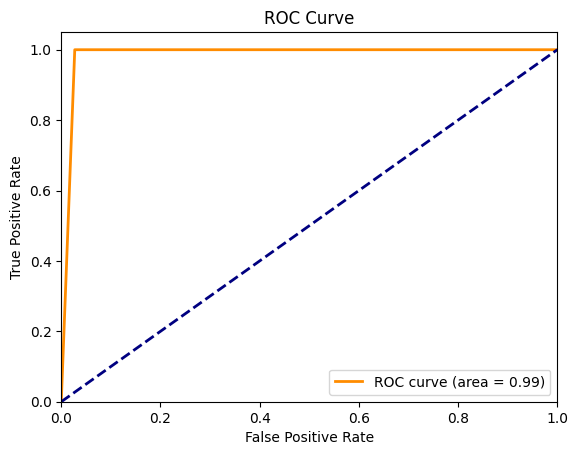

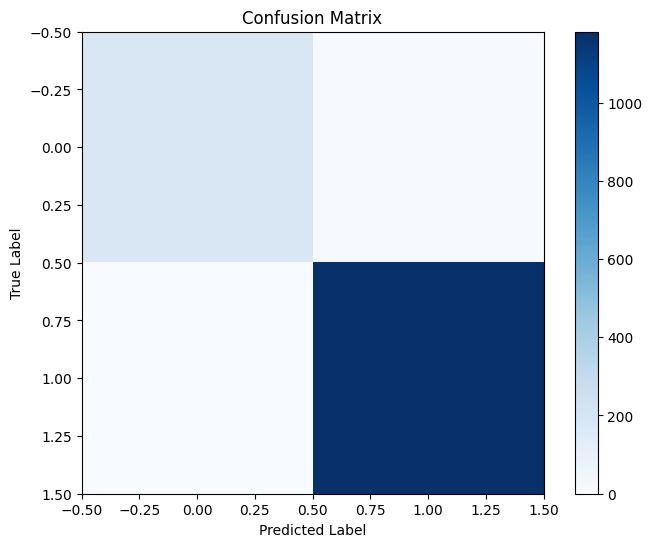

In [16]:
#matplot이용한 결과 시각화

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

# 예측 생성
y_pred = best_model.predict(X_test)

# 혼동 행렬 생성
confusion = confusion_matrix(y_test, y_pred)

# ROC 곡선 생성
fpr, tpr, _ = roc_curve(y_test, y_pred)  # ROC 곡선의 거짓 양성 비율 및 참 양성 비율 계산
roc_auc = auc(fpr, tpr)  # ROC 곡선 아래 영역(AUC) 계산

# ROC 곡선 시각화
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)  # ROC 곡선 그리기
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 대각선 기준선 그리기
plt.xlim([0.0, 1.0])  # X 축 범위 설정
plt.ylim([0.0, 1.05])  # Y 축 범위 설정
plt.xlabel('False Positive Rate')  # X 축 레이블 설정
plt.ylabel('True Positive Rate')  # Y 축 레이블 설정
plt.title('ROC Curve')  # 그래프 제목 설정
plt.legend(loc='lower right')  # 범례 위치 설정
plt.show()  # 그래프 출력

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))  # 그림 크기 설정
plt.imshow(confusion, cmap='Blues', interpolation='nearest')  # 혼동 행렬 그리기
plt.colorbar()  # 컬러 바 추가
plt.title('Confusion Matrix')  # 그래프 제목 설정
plt.xlabel('Predicted Label')  # X 축 레이블 설정
plt.ylabel('True Label')  # Y 축 레이블 설정
plt.show()  # 그래프 출력

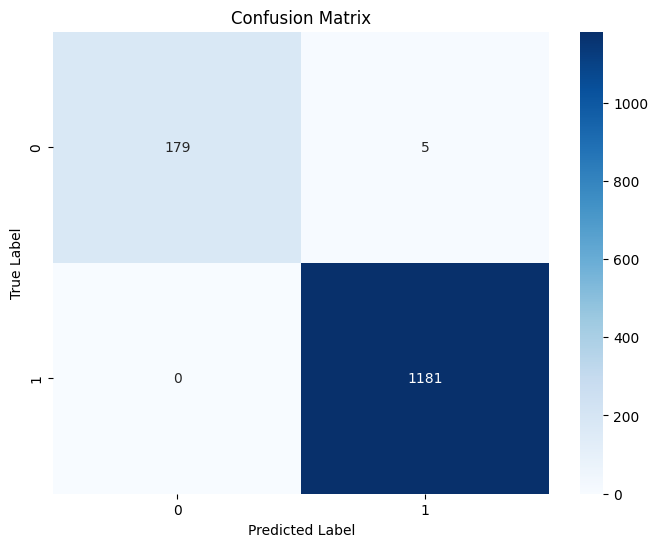

In [17]:
#seaborn 사용

import seaborn as sns

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))  # 그림 크기 설정
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")  # 혼동 행렬 그리기
plt.title('Confusion Matrix')  # 그래프 제목 설정
plt.xlabel('Predicted Label')  # X 축 레이블 설정
plt.ylabel('True Label')  # Y 축 레이블 설정
plt.show()  # 그래프 출력